# Bilevel ROF Scalar Parameter Learning
In this notebook we will propose an optimal parameter learning methodology for getting the optimal parameter for the scalar ROF image denoising model.

$$
\min \|\bar{u}-z\|^2 + \frac{\alpha}{2}\|\lambda\|^2\\
\text{s.t. }\lambda \langle \bar{u},v-\bar{u} \rangle + \|\mathbb{K}v\|_{2,1} - \|\mathbb{K}\bar{u}\|_{2,1} \ge \langle f,v-\bar{u} \rangle
$$

where $\|\cdot\|_{2,1}$ is the Total Variation seminorm.

In [1]:
using LinearAlgebra, StructuredOptimization, AbstractOperators, Plots, Distributed, Images, ImageQualityIndexes

## Cost Function and Lower Level Solver

In [17]:
# Lower Level Solver
function lower_level_solver(u,f,λ,K)
    @minimize 0.5*λ*ls(-(1/λ)*K'*u+f) + conj(norm(u,2,1,2)) with ForwardBackward(tol = 1e-4, gamma = 1/8, fast = true) 
    return -(1/λ)*K'*(~u)+f
end

# Upper level cost
function upper_level_cost(u,z,λ,α)
    return 0.5*norm(u[:]-z[:])^2 + 0.5*α*norm(λ)^2
end

upper_level_cost (generic function with 1 method)

In [18]:
m,n = 32,32
f = tril(ones(m,n)) + 0.2*randn(m,n)
f[f .< 0] .= 0.
f[f .> 1] .= 1.
z = tril(ones(m,n));

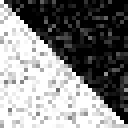

In [19]:
Gray.(f)

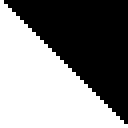

In [20]:
Gray.(z)

0.5513656052416068, 4.784691553783078
0.2738073727525441, 9.332372376875417


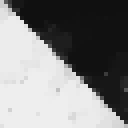

In [24]:
u_h = lower_level_solver(u,f,10,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,10,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,10,α))")
Gray.(u_h)

In [209]:
step = 0.001
lambda_min = 9
lambda_max = 10

K = Variation(size(f))
u = Variable(size(K,1)...)
α = 1e-2

lambda_range = lambda_min:step:lambda_max
costs = Float64[]
ssims = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    push!(costs,upper_level_cost(u_h,z,λ,α))
    push!(ssims,ssim(u_h,z))
    if λ == lambda_range[end]
        print("$(round(λ,digits=3)), ")
    end
end

10.0, 

Task (done) @0x0000000120ea5210

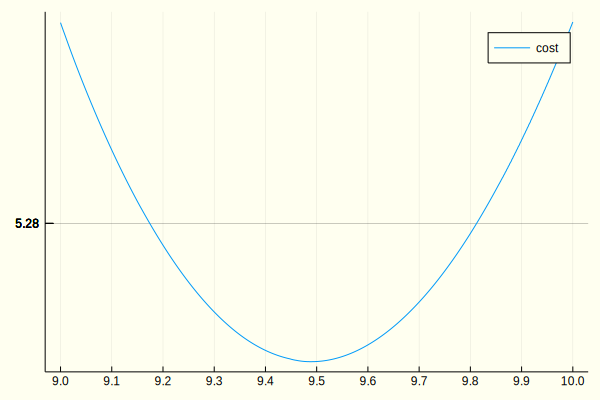

In [210]:
plot(lambda_range,costs,label="cost",xticks = 0:0.1:lambda_max, background_color = :ivory)

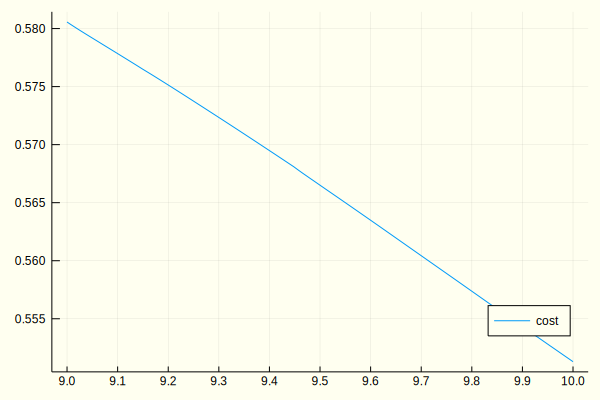

In [211]:
plot(lambda_range,ssims,label="cost",xticks = 0:0.1:lambda_max, background_color = :ivory, legend=:bottomright)

## Gradient Calculation
Let us consider a reduced cost function

$$
j(\lambda) = \frac{1}{2}\|S(\lambda)-z\|^2+\frac{\alpha}{2}\|\lambda\|^2,
$$

its directional derivative will be given by

$$
j'(\lambda)h = \langle S(\lambda)-z, S'(\lambda)h \rangle + \alpha \langle \lambda, h \rangle
$$

In [96]:
include("gradient_solver.jl")

gradient_solver (generic function with 2 methods)

In [142]:
λ = 17.0859
∇ = gradient_matrix(size(f))
u_h= lower_level_solver(u,f,λ,K)
grad = gradient_solver(u_h,f,z,λ,α,K,∇)

0.1745544326740889

In [140]:
step = 0.1
lambda_max = 40.0
lambda_min = 1
lambda_range = lambda_min:step:lambda_max
grads = Float64[]

K = Variation(size(f))
u = Variable(size(K,1)...)
α = 1e-2

@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    g = gradient_solver(u_h,f,z,λ,α,K,∇)
    push!(grads,g)
    if λ % 10 == 0
        print("$(round(λ,digits=3)), ")
    end
end

10.0, 20.0, 30.0, 40.0, 

Task (done) @0x000000011eb2f190

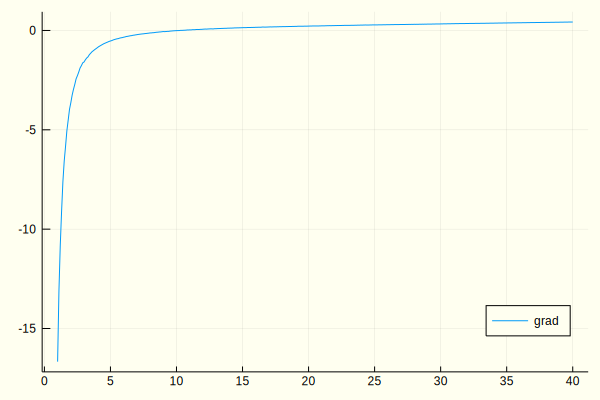

In [141]:
plot(lambda_range,grads,label="grad",xticks = 0:5:lambda_max, background_color = :ivory, legend=:bottomright)
#plot!(lambda_range,costs,label="cost",xticks = 0:5:lambda_max, background_color = :ivory, legend=:bottomright)

## Trust Region Algorithm
We will use a nonsmooth trust region strategy to solve this problem. This method will consider a local quadratic model described by 

$$
q_k(s) = j(\lambda_k)+g_k^\top s + \frac{1}{2}s^\top H_k s
$$

where $s$ is the descent direction, $g_k$ will be the gradient at iteration $k$ and $H_k$ will be a matrix with second order information that can be obtained using SR1 or BFGS method.
The trust region radius will be $\Delta_k$ and the actual and predicted reductions are given by

$$
ared(s_k) := j(\lambda_k)-j(\lambda_k+s_k),\;pred(s_k) := j(\lambda_k)-q_k(s_k)
$$

and the step quality will be given by the following quotient

$$
\rho_k(s_k) = \frac{ared(s_k)}{pred(s_k)}
$$

In [207]:
include("trust_region_solver.jl")

trust_region_solver (generic function with 2 methods)

In [203]:
K = Variation(size(f))
u = Variable(size(K,1)...)
α = 1e-2

lambda_0 = 1
radius_0 = 0.6
tol = 1e-5

1.0e-5

In [204]:
model = 1
lambda_opt_1 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model)

TR Iteration 1: 	lambda = 1.0, rho_k = 0.604, radius = 0.6, g_k = -16.67, s_k = 0.6, H_k = 0.0
TR Iteration 2: 	lambda = 1.6, rho_k = 0.722, radius = 0.6, g_k = -5.849, s_k = 0.6, H_k = 0.0
TR Iteration 3: 	lambda = 2.2, rho_k = 0.781, radius = 0.6, g_k = -2.989, s_k = 0.6, H_k = 0.0
TR Iteration 4: 	lambda = 2.8, rho_k = 0.75, radius = 0.9, g_k = -1.79, s_k = 0.9, H_k = 0.0
TR Iteration 5: 	lambda = 3.7, rho_k = 0.754, radius = 1.35, g_k = -1.025, s_k = 1.35, H_k = 0.0
TR Iteration 6: 	lambda = 5.05, rho_k = 0.674, radius = 2.025, g_k = -0.523, s_k = 2.025, H_k = 0.0
TR Iteration 7: 	lambda = 7.075, rho_k = 0.517, radius = 2.025, g_k = -0.206, s_k = 2.025, H_k = 0.0
TR Iteration 8: 	lambda = 9.1, rho_k = -0.556, radius = 2.025, g_k = -0.061, s_k = 2.025, H_k = 0.0
TR Iteration 9: 	lambda = 9.1, rho_k = -0.127, radius = 1.0125, g_k = -0.052, s_k = 1.012, H_k = 0.0
TR Iteration 10: 	lambda = 9.1, rho_k = 0.174, radius = 0.5062, g_k = -0.051, s_k = 0.506, H_k = 0.0
TR Iteration 11: 	lamb

TR Iteration 82: 	lambda = 9.3622, rho_k = 0.264, radius = 0.0001, g_k = -0.045, s_k = 0.0, H_k = 0.0
TR Iteration 83: 	lambda = 9.3623, rho_k = 0.264, radius = 0.0001, g_k = -0.045, s_k = 0.0, H_k = 0.0
TR Iteration 84: 	lambda = 9.3623, rho_k = 0.264, radius = 0.0001, g_k = -0.045, s_k = 0.0, H_k = 0.0
TR Iteration 85: 	lambda = 9.3624, rho_k = 0.263, radius = 0.0001, g_k = -0.046, s_k = 0.0, H_k = 0.0
TR Iteration 86: 	lambda = 9.3625, rho_k = 0.262, radius = 0.0001, g_k = -0.046, s_k = 0.0, H_k = 0.0
TR Iteration 87: 	lambda = 9.3625, rho_k = 0.262, radius = 0.0001, g_k = -0.046, s_k = 0.0, H_k = 0.0
TR Iteration 88: 	lambda = 9.3626, rho_k = 0.261, radius = 0.0001, g_k = -0.046, s_k = 0.0, H_k = 0.0
TR Iteration 89: 	lambda = 9.3626, rho_k = 0.261, radius = 0.0001, g_k = -0.046, s_k = 0.0, H_k = 0.0
TR Iteration 90: 	lambda = 9.3627, rho_k = 0.26, radius = 0.0001, g_k = -0.046, s_k = 0.0, H_k = 0.0
TR Iteration 91: 	lambda = 9.3628, rho_k = 0.259, radius = 0.0001, g_k = -0.046, s_

9.364743041992247

0.5706219290989778, 5.277296505984371
0.2738073727525441, 9.770864433088128


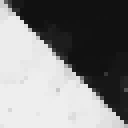

In [205]:
u_h = lower_level_solver(u,f,lambda_opt_1,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,lambda_opt_1,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,lambda_opt_1,α))")
Gray.(u_h)

In [208]:
model = 2
lambda_opt_2 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model)

TR Iteration 1: 	lambda = 1.0, rho_k = 0.605, radius = 0.6, g_k = -16.67, s_k = 0.6, H_k = 0.1
TR Iteration 2: 	lambda = 1.6, rho_k = 9.618, radius = 0.6, g_k = -5.849, s_k = 0.6, H_k = 18.03
TR Iteration 3: 	lambda = 2.2, rho_k = 1.074, radius = 0.9, g_k = -2.989, s_k = 0.166, H_k = 4.77
TR Iteration 4: 	lambda = 2.3658, rho_k = 1.196, radius = 1.35, g_k = -2.509, s_k = 0.526, H_k = 2.9
TR Iteration 5: 	lambda = 2.8921, rho_k = 1.205, radius = 2.025, g_k = -1.628, s_k = 0.562, H_k = 1.67
TR Iteration 6: 	lambda = 3.4539, rho_k = 1.141, radius = 3.0375, g_k = -1.131, s_k = 0.676, H_k = 0.89
TR Iteration 7: 	lambda = 4.1298, rho_k = 1.214, radius = 4.5562, g_k = -0.812, s_k = 0.917, H_k = 0.47
TR Iteration 8: 	lambda = 5.0464, rho_k = 1.254, radius = 6.8344, g_k = -0.52, s_k = 1.103, H_k = 0.32
TR Iteration 9: 	lambda = 6.149, rho_k = 1.125, radius = 10.2516, g_k = -0.317, s_k = 0.998, H_k = 0.18
TR Iteration 10: 	lambda = 7.1473, rho_k = 1.089, radius = 15.3773, g_k = -0.195, s_k = 1.0

10.149620643423267

0.5654494337646324, 5.276902973390568
0.2738073727525441, 9.787355444047162


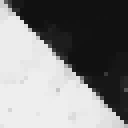

In [201]:
u_h = lower_level_solver(u,f,lambda_opt_2,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,lambda_opt_2,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,lambda_opt_2,α))")
Gray.(u_h)

In [194]:
model = 3
lambda_opt_3 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model)

TR Iteration 1: 	lambda = 2.0, rho_k = 0.66, radius = 1.0, g_k = -3.687, s_k = 1.0, H_k = 0.1
TR Iteration 2: 	lambda = 3.0, rho_k = 2.149, radius = 1.0, g_k = -1.585, s_k = 1.0, H_k = 2.1
TR Iteration 3: 	lambda = 4.0, rho_k = 1.229, radius = 1.5, g_k = -0.83, s_k = 0.395, H_k = 0.75
TR Iteration 4: 	lambda = 4.3947, rho_k = 1.104, radius = 2.25, g_k = -0.71, s_k = 0.94, H_k = 0.3
TR Iteration 5: 	lambda = 5.3351, rho_k = 1.315, radius = 3.375, g_k = -0.46, s_k = 1.511, H_k = 0.27
TR Iteration 6: 	lambda = 6.8456, rho_k = 1.083, radius = 5.0625, g_k = -0.232, s_k = 0.873, H_k = 0.15
TR Iteration 7: 	lambda = 7.7182, rho_k = 0.898, radius = 7.5938, g_k = -0.15, s_k = 0.994, H_k = 0.09
TR Iteration 8: 	lambda = 8.7124, rho_k = 0.527, radius = 11.3906, g_k = -0.077, s_k = 0.827, H_k = 0.07
TR Iteration 9: 	lambda = 9.5392, rho_k = -0.925, radius = 11.3906, g_k = -0.025, s_k = 0.339, H_k = 0.06
TR Iteration 10: 	lambda = 9.5392, rho_k = -1.163, radius = 5.6953, g_k = -0.031, s_k = 0.494, 

9.539214560662161

0.5653984287665884, 5.276896777188253
0.2738073727525441, 9.787355444047162


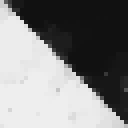

In [195]:
u_h = lower_level_solver(u,f,lambda_opt_3,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,lambda_opt_3,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,lambda_opt_3,α))")
Gray.(u_h)

0.6938079902043084
0.5237925111569598


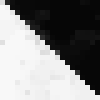

In [127]:
u_h = lower_level_solver(u,f,0.035,K)
println(ssim(u_h,z))
println(ssim(f,z))
Gray.(u_h)